In [1]:
from scipy import optimize
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from matplotlib.ticker import MultipleLocator
from math import sqrt
from math import cos
from math import pi
from scipy import stats

1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

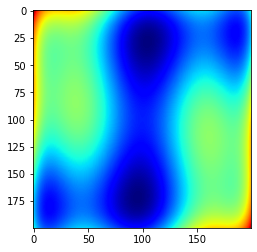

In [2]:
f = lambda x: (4 - 2.1*(x[0]**2) + (x[0]**4)/3) * (x[0]**2) + x[0]*x[1] + (4*(x[1]**2) - 4) * (x[1]**2)

step = 0.01
x = np.arange(-2, 2, step * 2)
y = np.arange(-1, 1, step)

x2, y2 = np.meshgrid(x, y)
z = f([x2, y2])

plt.imshow(z, cmap= 'jet')

In [3]:
res1 = optimize.minimize(f, [-2, -1])
res2 = optimize.minimize(f, [2, 1])

print("solution 1: \n", res1)
print("\nsolution 2: \n", res2)
print("\nThere are 2 global minima with result = ", res1['fun'])
print("and input parameters = ", res1['x'], " and ", res2['x'])

solution 1: 
       fun: -1.0316284534896594
 hess_inv: array([[ 0.12675633, -0.00599026],
       [-0.00599026,  0.06008279]])
      jac: array([-1.19209290e-06,  1.92224979e-06])
  message: 'Optimization terminated successfully.'
     nfev: 51
      nit: 12
     njev: 17
   status: 0
  success: True
        x: array([ 0.08984184, -0.71265628])

solution 2: 
       fun: -1.0316284534896498
 hess_inv: array([[ 0.12675641, -0.0059902 ],
       [-0.0059902 ,  0.06008279]])
      jac: array([ 1.17719173e-06, -1.92224979e-06])
  message: 'Optimization terminated successfully.'
     nfev: 51
      nit: 12
     njev: 17
   status: 0
  success: True
        x: array([-0.08984185,  0.71265627])

There are 2 global minima with result =  -1.0316284534896594
and input parameters =  [ 0.08984184 -0.71265628]  and  [-0.08984185  0.71265627]


In [4]:
res3 = optimize.minimize(f, [0, 0])
print("solution 3: \n", res3)
print("\nwith initial parameters equals to [0, 0] the algorithm remains stucked in that local minima")

solution 3: 
       fun: 0.0
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([ 5.96046448e-08, -5.96046448e-08])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0., 0.])

with initial parameters equals to [0, 0] the algorithm remains stucked in that local minima


2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

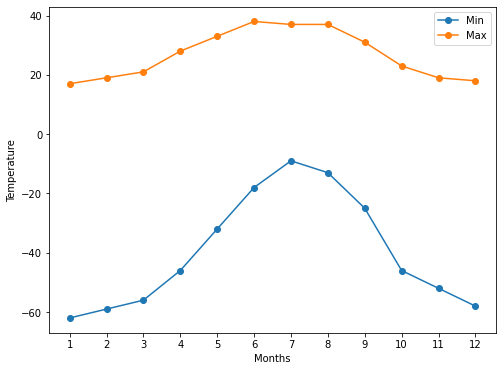

In [5]:
t_max = [17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18]
t_min = [-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]

months = np.arange(1, len(t_max) + 1)

fig, ax = plt.subplots( figsize=(8, 6))
ax.plot(months, t_min, label='Min', marker='o')
ax.plot(months, t_max, label='Max', marker='o')
ax.set_xlabel('Months')
ax.set_ylabel('Temperature')
ax.legend()
ax.xaxis.set_major_locator(MultipleLocator(1))


To fit max and min temperatures I use the gaussian function with a parameter b used as bias to move the function across the y axis 



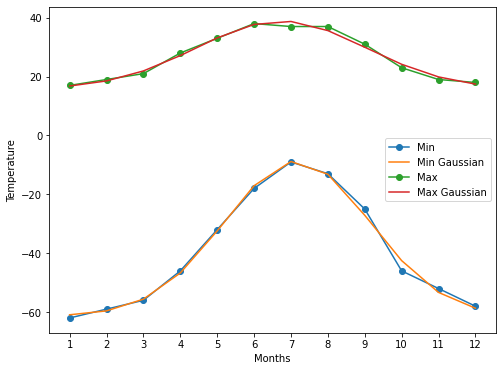


results obtained are quite reasonable.


In [6]:
print("\nTo fit max and min temperatures I use the gaussian function with a parameter b used as bias to move the function across the y axis \n")
def gaus(x,a,b,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2)) + b

popt_max, pcov_max = optimize.curve_fit(gaus, months, t_max, full_output=False, p0=[ 1, 0, 7, 1])
popt_min, pcov_min = optimize.curve_fit(gaus, months, t_min, full_output=False, p0=[ 1, 0, 7, 1])

fig, ax = plt.subplots( figsize=(8, 6))

ax.plot(months, t_min, label='Min', marker='o')
ax.plot(months, gaus(months, popt_min[0], popt_min[1], popt_min[2], popt_min[3]), label='Min Gaussian')
ax.plot(months, t_max, label='Max', marker='o')
ax.plot(months, gaus(months, popt_max[0], popt_max[1], popt_max[2], popt_max[3]), label='Max Gaussian')

ax.set_xlabel('Months')
ax.set_ylabel('Temperature')
ax.legend()
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.show()

print("\nresults obtained are quite reasonable.")

In [7]:
offset_real_data = np.array(t_max) - np.array(t_min)
offset_fit = gaus(months, popt_max[0], popt_max[1], popt_max[2], popt_max[3]) - gaus(months, popt_min[0], popt_min[1], popt_min[2], popt_min[3])
offset = np.absolute(offset_real_data - offset_fit)

print(offset)
print("\nOffset between real data and the fitted data is low, we can conclude that obtained results are satisfactory.")

[1.29014703 0.11465989 0.52313606 0.15847955 0.55154659 1.22049242
 1.57269254 1.20674273 1.09194425 2.30839612 2.20466788 0.12561066]

Offset between real data and the fitted data is low, we can conclude that obtained results are satisfactory.


3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

In [8]:
# retrieve data
data = pd.read_pickle("data/residuals_261.pkl")
df = pd.DataFrame(data.item(0))
display(df)

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
2,-7.200000,3.4
3,-4.150000,8.4
4,-6.590000,1.7
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


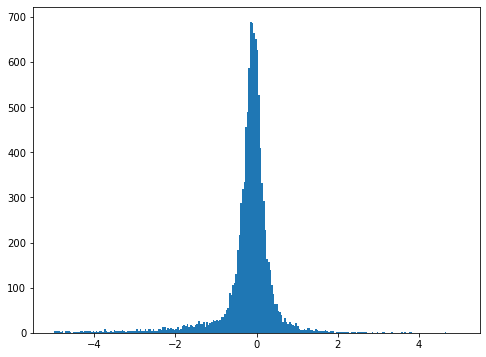

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
n_bin = 250
h, bins, _ = ax.hist(df['residuals'], bins=n_bin, range = (-5, 5), density=False, cumulative=False)

In [10]:
bin_centers = (bins[1:] + bins[:-1]) / 2
h_err_poisson = np.sqrt(h)

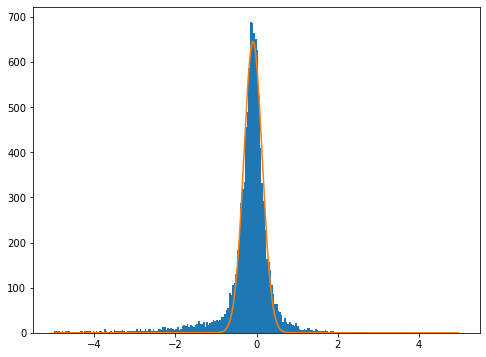

In [11]:
def gauss(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

popt, pcov = optimize.curve_fit(gauss, bin_centers, h, full_output=False, p0=[ 1, 0, 1])

fig, ax = plt.subplots(figsize=(8, 6))
h, bins, _ = ax.hist(df['residuals'], bins=n_bin, range = (-5, 5), density=False, cumulative=False)
ax.plot(bin_centers, gauss(bin_centers, popt[0], popt[1], popt[2]))

In [12]:
ssr = np.sum((h - gauss(bin_centers, popt[0], popt[1], popt[2]))**2)
tss = np.sum((np.mean(h) - h)**2)

rsq = 1 - ssr / tss

print("R2 =", rsq, "\nR =", sqrt(rsq))

R2 = 0.9809890242690256 
R = 0.9904489003825616


In [13]:
ndof = n_bin - 1

print("n degrees of freedom =", ndof)
h_err_poisson [h_err_poisson == 0] = 0.00000001

chi2 = np.sum(((h - gauss(bin_centers, popt[0], popt[1], popt[2]))**2) / h_err_poisson)
print("chi2 =", chi2)

pvalue = 1. - stats.chi2.cdf(chi2, ndof)
print("p-value =", pvalue)

n degrees of freedom = 249
chi2 = 9022.737045909269
p-value = 0.0


4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

In [14]:
df = pd.read_csv("data/munich_temperatures_average_with_bad_data.txt", delimiter=" ", names=['Date', 'Temperature'])
# display (df)

mask = (df['Date']>=2008) & (df['Date']<=2012)
df = df[mask]

# remove noisy measurements
df = df[df['Temperature'] < 40]

display (df)

,Date,Temperature
4748,2008.00274,-2.94444
4749,2008.00548,-2.66667
4750,2008.00821,-2.66667
4751,2008.01095,-2.00000
4752,2008.01369,-1.94444
...,...,...
6204,2011.98836,3.44444
6205,2011.99110,1.27778
6206,2011.99384,2.88889
6207,2011.99658,1.83333


Best values are: 

a =  -9.962034672377369
b =  12.331742861926209
c =  9.262821312957865


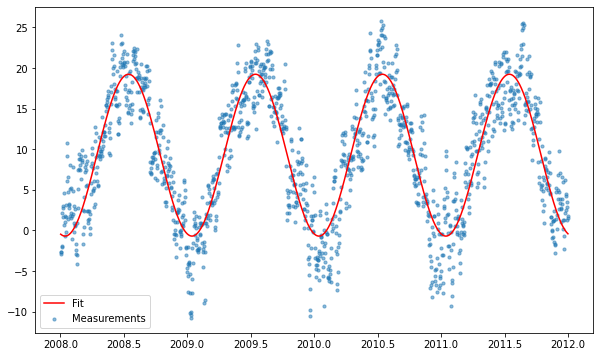

In [15]:
f = lambda t, a, b, c: a * np.cos(2 * pi * t + b) + c 

popt, pcov = optimize.curve_fit(f, df['Date'], df['Temperature'], full_output=False)

print("Best values are: \n")
print("a = ", popt[0])
print("b = ", popt[1])
print("c = ", popt[2])

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df['Date'], df['Temperature'], label='Measurements', alpha=0.5, s=10)
ax.plot(df['Date'], f(df['Date'], popt[0], popt[1], popt[2]), label='Fit', c='red')
ax.legend()

In [16]:
t_avg = df["Temperature"].mean()
print("Overall average temperature : ", t_avg)

t_fitted = f(df['Date'], popt[0], popt[1], popt[2])
t_coldest = t_fitted.min()
t_hottest = t_fitted.max()
print("Coldest fitted temperature : ", t_coldest)
print("Hottest fitted temperature : ", t_hottest)

Overall average temperature :  9.261252084167236
Coldest fitted temperature :  -0.6990214731851534
Hottest fitted temperature :  19.224753431519183


The b parameter let the function shift along the x axis.
This permits to adjust the correct shape with respect to Date.


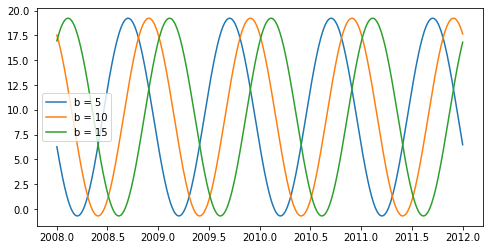

In [17]:
print("The b parameter let the function shift along the x axis.")
print("This permits to adjust the correct shape with respect to Date.")

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(df['Date'], f(df['Date'], popt[0], 5, popt[2]), label='b = 5')
ax.plot(df['Date'], f(df['Date'], popt[0], 10, popt[2]), label='b = 10')
ax.plot(df['Date'], f(df['Date'], popt[0], 15, popt[2]), label='b = 15' )
ax.legend()

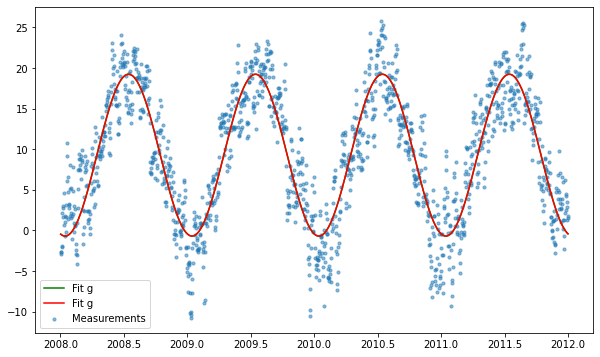

In [18]:
g = lambda t, a, b, c, d: a * np.cos(2 * pi * b * t + c) + d

popt_g, pcov_g = optimize.curve_fit(g, df['Date'], df['Temperature'], full_output=False)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df['Date'], df['Temperature'], label='Measurements', alpha=0.5, s=10)
ax.plot(df['Date'], f(df['Date'], popt[0], popt[1], popt[2]), label='Fit g', c='green')
ax.plot(df['Date'], g(df['Date'], popt_g[0], popt_g[1], popt_g[2], popt_g[3]), label='Fit g', c='red')
ax.legend()

In [23]:
def Ftest(ssr_1, ssr_2, ndof_1, ndof_2, nbins, verbose=False):
    F = ((ssr_1 - ssr_2)/(ndof_2 - ndof_1)) / (ssr_2/(nbins - ndof_2))
    CL = 1. - stats.f.cdf(F, ndof_2 - ndof_1, nbins - ndof_2)
    if verbose: print("CL: %.3f" % CL, ", additional parameter necessary:", "YES" if CL < 0.10 else "NO")
    return CL

ssr_f = np.sum((df['Temperature'] - f(df['Date'], popt[0], popt[1], popt[2]))**2)
ssr_g = np.sum((df['Temperature'] - g(df['Date'], popt_g[0], popt_g[1], popt_g[2], popt_g[3]))**2)

print("SSR f : ", ssr_f)
print("SSR g : ", ssr_g)

print("\nTest f(3 parameters) vs g(4 parameters):")
cl_3_vs_4 = Ftest(ssr_f, ssr_g, 3, 4, len(df['Temperature']), verbose=True)


SSR f :  18669.515394578364
SSR g :  18669.225430956096

Test f(3 parameters) vs g(4 parameters):
CL: 0.881 , additional parameter necessary: NO
